<a href="https://colab.research.google.com/github/aryamanpandya99/AIFundamentals/blob/master/MLPy/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

By Definition, an autoencoder is a neural network trained to downsize then reconstruct its input data from a latent representation. A convolutional autoencoder uses a CNN encoder to compress the input into the a latent representation and a deconvolutional (transposed convolution) decoder to reconstruct the input from the latent representation.

In [174]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib.pyplot as plt, numpy as np

In [176]:
import pandas as pd
import pathlib as Path
from torch.utils.data import DataLoader, default_collate, Dataset
from typing import Mapping

In [177]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [178]:
with open('/content/drive/MyDrive/data/cifar-10-batches-py/data_batch_1', 'rb') as f:
    dataset_dict = pickle.load(f, encoding='bytes')

In [179]:
dataset_dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [180]:
dataset_dict[b'data'][0].shape

(3072,)

In [181]:
dataset_dict[b'batch_label']

b'training batch 1 of 5'

In [182]:
dataset_dict[b'labels'][0]

6

In [183]:
data = dataset_dict[b'data']
labels = dataset_dict[b'labels']

data = torch.tensor(data, dtype=torch.float32).view(-1, 3, 32, 32).to(device)
labels = torch.tensor(labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)

print("Validation data shape:", x_valid.shape)
print("Validation labels shape:", y_valid.shape)

Training data shape: torch.Size([8000, 3, 32, 32])
Training labels shape: torch.Size([8000])
Validation data shape: torch.Size([2000, 3, 32, 32])
Validation labels shape: torch.Size([2000])


In [184]:
# sample cnn
from torch import nn

simple_cnn = nn.Sequential(
    nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),    # 14x14x4
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),    # 7x7x8
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),    # 4x4x16
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),    # 2x2x16
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),    # 1x1x10
    nn.Flatten(),
).to(device)

simple_cnn(x_train[0].unsqueeze(0))

tensor([[-0.2784,  0.1295, -0.0953,  0.2713, -0.1485, -0.0411,  0.5143,  0.5460,
          0.3264, -0.2419]], device='cuda:0', grad_fn=<ViewBackward0>)

In [185]:
X = x_train.reshape(8000, 3, 32, 32)

In [186]:
X.shape

torch.Size([8000, 3, 32, 32])

In [187]:
def show_torch_image(img):
    img = img.permute(1, 2, 0)
    img = img.numpy().astype(np.uint8)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

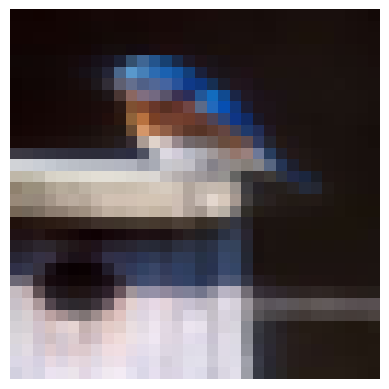

In [188]:
show_torch_image(X[13].cpu())

In [189]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [190]:
def validate(model, loss_func, valid_dl):
    model.eval()
    with torch.no_grad():
        tot_loss = 0.
        count = 0
        for xb, _ in valid_dl:
            pred = model(xb)
            loss = loss_func(255 * pred, xb)
            tot_loss += loss.item()
            count += len(xb)
    return tot_loss / count

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(255 * pred, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        tot_loss_count = validate(model, loss_func, valid_dl)
        print(f"Validation loss: {tot_loss_count}")

In [191]:
class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [192]:
train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

In [193]:
print(len(train_ds))

8000


In [194]:
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [195]:
model = ConvolutionalAutoencoder()
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)

ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(4, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [196]:
fit(20, model, loss_func, opt, train_dl, valid_dl)

Epoch 1/20
Validation loss: 50.50830242919922
Epoch 2/20
Validation loss: 35.94436700439453
Epoch 3/20
Validation loss: 26.597008361816407
Epoch 4/20
Validation loss: 21.458172424316405
Epoch 5/20
Validation loss: 19.53983297729492
Epoch 6/20
Validation loss: 17.469692276000977
Epoch 7/20
Validation loss: 18.051514358520507
Epoch 8/20
Validation loss: 15.73802146911621
Epoch 9/20
Validation loss: 15.17412321472168
Epoch 10/20
Validation loss: 14.534107650756836
Epoch 11/20
Validation loss: 14.290028594970703
Epoch 12/20
Validation loss: 14.552046173095704
Epoch 13/20
Validation loss: 13.781539093017578
Epoch 14/20
Validation loss: 14.271948013305664
Epoch 15/20
Validation loss: 13.068374374389649
Epoch 16/20
Validation loss: 13.081239013671874
Epoch 17/20
Validation loss: 12.88365542602539
Epoch 18/20
Validation loss: 12.846498001098633
Epoch 19/20
Validation loss: 12.671963745117187
Epoch 20/20
Validation loss: 12.407222274780274


torch.Size([1, 3, 32, 32])


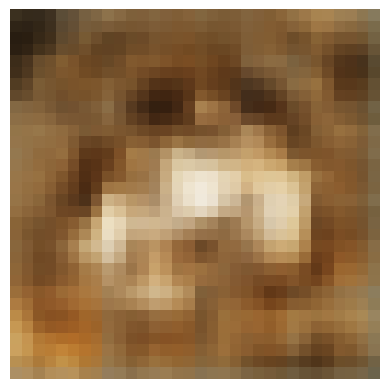

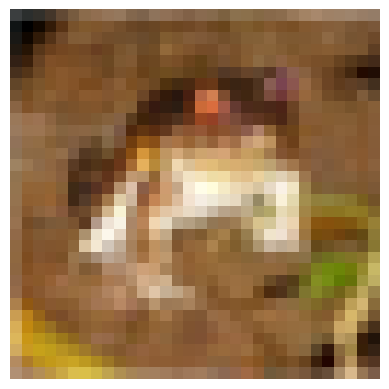

In [200]:
sample_output = model(x_train[0].unsqueeze(0))
print(sample_output.shape)
show_torch_image(255*sample_output.squeeze(0).detach().cpu())
show_torch_image(x_train[0].cpu())

In [198]:
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
fit(20, model, loss_func, opt, train_dl, valid_dl)

Epoch 1/20
Validation loss: 12.237098663330078
Epoch 2/20
Validation loss: 12.213099670410156
Epoch 3/20
Validation loss: 12.130977188110352
Epoch 4/20
Validation loss: 12.139846649169922
Epoch 5/20
Validation loss: 12.066892196655273
Epoch 6/20
Validation loss: 12.026760879516601
Epoch 7/20
Validation loss: 12.037713577270507
Epoch 8/20
Validation loss: 11.979642105102538
Epoch 9/20
Validation loss: 11.952119216918945
Epoch 10/20
Validation loss: 11.958146057128907
Epoch 11/20
Validation loss: 11.909054626464844
Epoch 12/20
Validation loss: 11.928581573486328
Epoch 13/20
Validation loss: 11.873871643066407
Epoch 14/20
Validation loss: 11.832427947998047
Epoch 15/20
Validation loss: 11.819747192382813
Epoch 16/20
Validation loss: 11.810047897338867
Epoch 17/20
Validation loss: 11.801602249145509
Epoch 18/20
Validation loss: 11.755910095214844
Epoch 19/20
Validation loss: 11.844455429077149
Epoch 20/20
Validation loss: 11.709431091308593


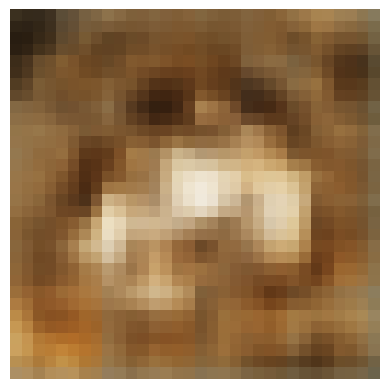

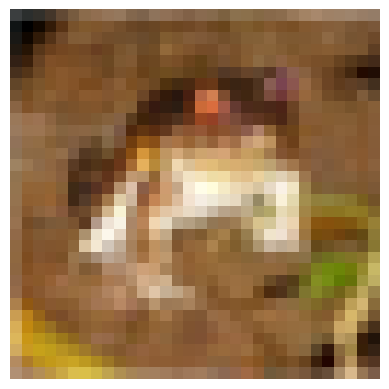

In [201]:
with torch.no_grad():
    sample_output = model(x_train[0].unsqueeze(0))
    show_torch_image(255*sample_output.squeeze(0).detach().cpu())
    show_torch_image(x_train[0].cpu())

## Observations

1. The more we compress with the encoder, the harder it gets to decode with the decoder. This makes sense intuitively, but still needed to be observed practically.

2. A learning rate decay helped marginally, but not substantially. In the above implementation, we might want to try out different tricks to improve model performance (like batch norm, dropout)

3. So far we've only trained our model with 10000 images. For 32x32x3 sized images, this is relatively low. We might want to train with an additional batch appended and see how that impacts performance.

4. Additional non-compressive layers don't seem to help given the current dataset size constraints.
